# Лабораторная работа №5 Логические методы классификации                                                                                                           
## Сергеев Никита 
Вариант 16

### Цель работы

изучение принципов построения информационных систем с использованием логических методов классификации.

### Задачи 

 - освоение технологии внедрения алгоритмов на онове решающих списков в приложения;
 - освоение технологии внедрения алгоритмов на онове решающих деревьев в приложения;
 - изучение параметров логической классификации;
 - освоение модификаций логических методов классификации.

## Ход работы:

### Загружаем набор данных

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
data_source = "./dataset/train.csv"
data = pd.read_csv(data_source, delimiter=',')
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### Оценим точность методом hold_out

In [7]:
data['Sex'] = data['Sex'].replace({'female': 0, 'male': 1})

mean_age = data['Age'].mean()
data['Age'].fillna(mean_age, inplace=True)
print(mean_age)

29.69911764705882


In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
y = data['Survived']
# Подмножества для hold-out
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=12)

# Обучение модели
tree = DecisionTreeClassifier(max_depth=5, 
                              random_state=21, 
                              max_features=2)
tree.fit(X_train, y_train)

# Получение оценки hold-out
tree_pred = tree.predict(X_holdout)
accur = accuracy_score(y_holdout, tree_pred)
print(accur)

0.7089552238805971


### Оценим точность модели по методу cross validation

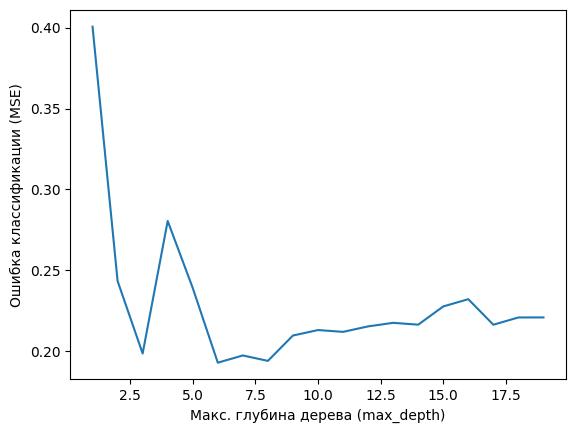

Оптимальные значения max_depth:  [6]


In [10]:
from sklearn.model_selection import cross_val_score

# Значения параметра max_depth
d_list = list(range(1,20))
# Пустой список для хранения значений точности
cv_scores = []
# В цикле проходим все значения K
for d in d_list:
    tree = DecisionTreeClassifier(max_depth=d, 
                                  random_state=21, 
                                  max_features=2)
    scores = cross_val_score(tree, X, y, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# Вычисляем ошибку (misclassification error)
MSE = [1-x for x in cv_scores]

# Строим график
plt.plot(d_list, MSE)
plt.xlabel('Макс. глубина дерева (max_depth)');
plt.ylabel('Ошибка классификации (MSE)')
plt.show()

# Ищем минимум
d_min = min(MSE)

# Пробуем найти прочие минимумы (если их несколько)
all_d_min = []
for i in range(len(MSE)):
    if MSE[i] <= d_min:
        all_d_min.append(d_list[i])

# печатаем все K, оптимальные для модели
print('Оптимальные значения max_depth: ', all_d_min)

### Проведем оценку точности cross validation по всем параметрам с помощью класса GridSearchCV

In [11]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import tree

dtc = DecisionTreeClassifier(max_depth=10, random_state=21, max_features=2)

tree_params = { 'max_depth': range(1,20), 'max_features': range(1,4) }
tree_grid = GridSearchCV(dtc, tree_params, cv=10, verbose=True, n_jobs=-1)
tree_grid.fit(X, y)

print('\n')
print('Лучшее сочетание параметров: ', tree_grid.best_params_)
print('Лучшие баллы cross validation: ', tree_grid.best_score_)

Fitting 10 folds for each of 57 candidates, totalling 570 fits


Лучшее сочетание параметров:  {'max_depth': 7, 'max_features': 3}
Лучшие баллы cross validation:  0.8148314606741573


### Построим и визуализируем дерево решений

In [13]:
from sklearn.tree import export_graphviz
# Генерируем графическое представление дерева
tree.export_graphviz(tree_grid.best_estimator_, 
                     feature_names=X.columns,
                     class_names=[str(x) for x in y.unique()],
                     out_file='./titanic.dot',  
                     filled=True, rounded=True);

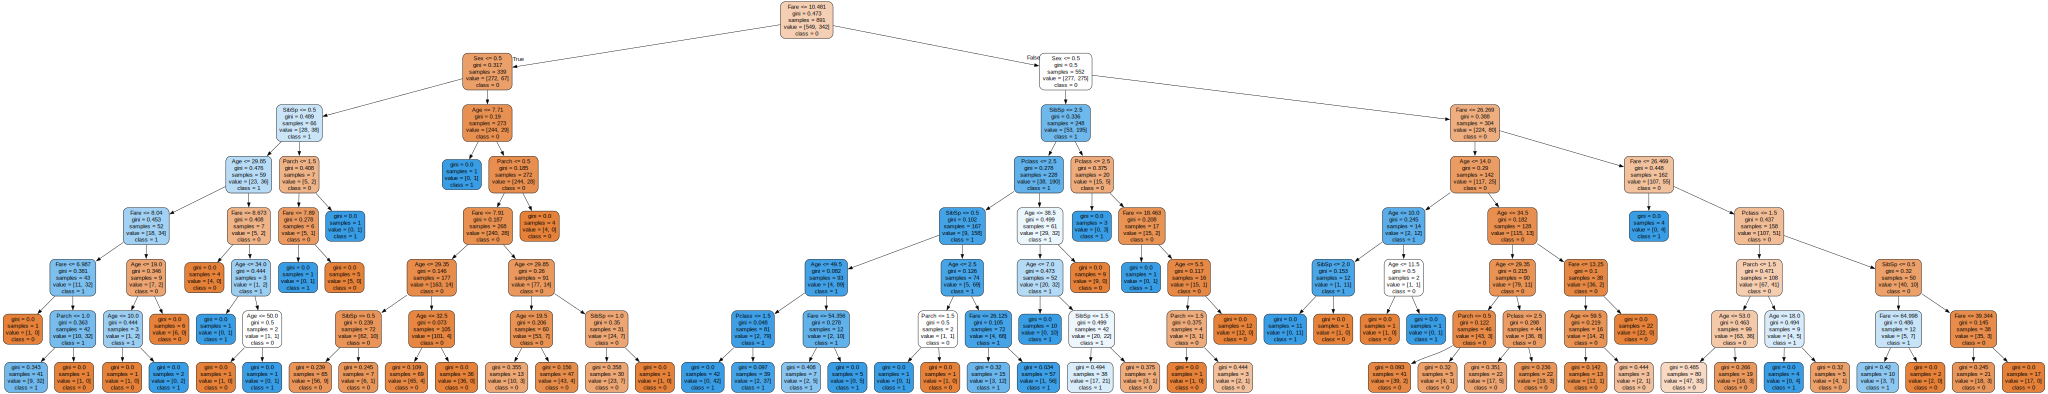

In [15]:
import os
import graphviz

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

with open('./titanic.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

### Построим дерево глубины 2

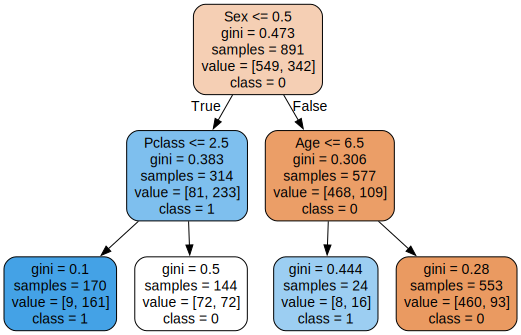

In [19]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# Создаем модель дерева решений с глубиной 2
tree_model = DecisionTreeClassifier(max_depth=2)

# Обучаем модель на данных
tree_model.fit(X, y)

# Генерируем графическое представление дерева
export_graphviz(tree_model, 
                feature_names=X.columns,
                class_names=[str(x) for x in y.unique()],
                out_file='./titanic_depth_2.dot',  
                filled=True, rounded=True)

with open('./titanic_depth_2.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

## Построим решающие границы

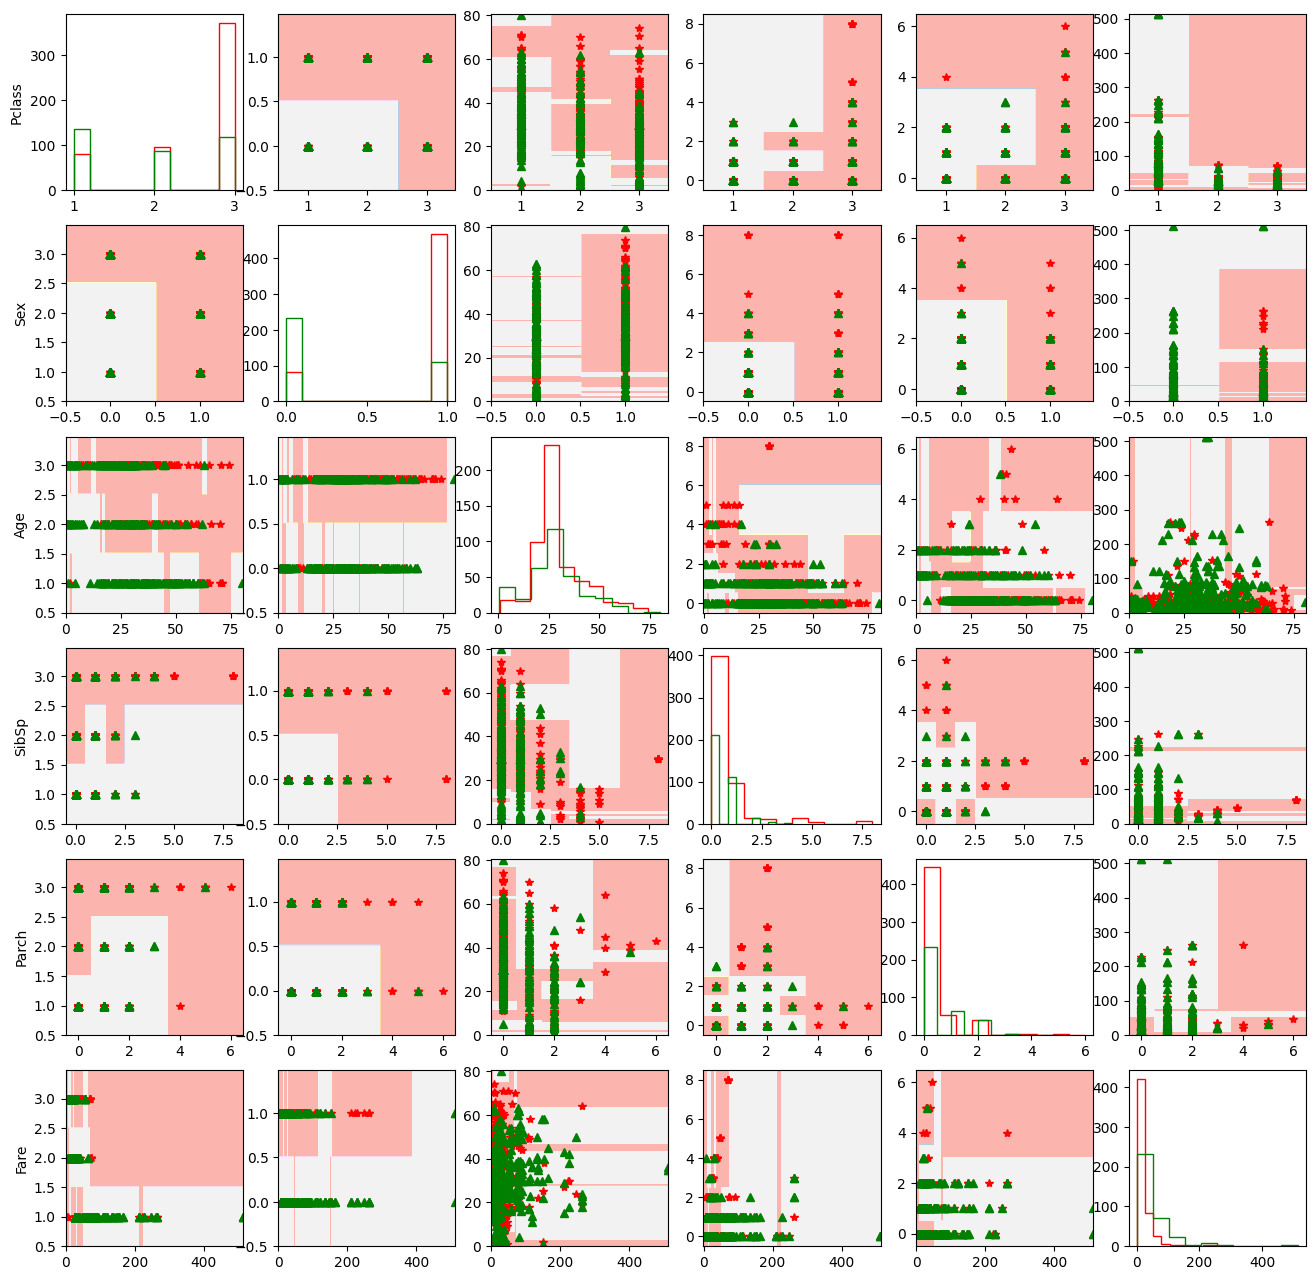

In [30]:
plot_markers = ['r*', 'g^']
answers = y.unique()

# Создаем подграфики для каждой пары признаков
f, places = plt.subplots(6, 6, figsize=(16,16))

fmin = X.min()-0.5
fmax = X.max()+0.5
plot_step = 0.02  

# Обходим все subplot
for i in range(0,6):
    for j in range(0,6):

        # Строим решающие границы 
        if(i != j):
            xx, yy = np.meshgrid(np.arange(fmin[i], fmax[i], plot_step),
                               np.arange(fmin[j], fmax[j], plot_step))
            model = DecisionTreeClassifier(max_depth=6, random_state=21, max_features=3)
            model.fit(X.iloc[:, [i,j]].values, y)
            p = model.predict(np.c_[xx.ravel(), yy.ravel()])
            p = p.reshape(xx.shape)
            p[p==answers[0]] = 0
            p[p==answers[1]] = 1
            xx = xx.astype(np.float32)
            yy = yy.astype(np.float32)
            p = p.astype(np.float32)
            places[i,j].contourf(xx, yy, p, cmap='Pastel1') 
      
        # Обход всех классов
        for id_answer in range(len(answers)):
            idx = np.where(y == answers[id_answer])
            if i==j:
                places[i, j].hist(X.iloc[idx].iloc[:,i],
                                  color=plot_markers[id_answer][0],
                                 histtype = 'step')
            else:
                places[i, j].plot(X.iloc[idx].iloc[:,i], X.iloc[idx].iloc[:,j], 
                                  plot_markers[id_answer], 
                                  label=answers[id_answer], markersize=6)
        
        if j==0:
            places[i, j].set_ylabel(X.columns[i])
        
        if i==6:
            places[i, j].set_xlabel(X.columns[j])
        
    

## Использование модели

In [33]:
dtc = DecisionTreeClassifier(max_depth=6, 
                             random_state=21, 
                             max_features=3)
dtc.fit(X.values, y.values)


# Использование классификатора
# Объявление признаков объекта

Pclass = float(input('Введите класс пассажира (1 — высший, 2 — средний, 3 — низший): '))
Sex = float(input('Введите пол пассажира (1 - мужчина, 0 - женщина): '))
Age = float(input('Введите возраст пассажира: '))
SibSp = float(input('Введите количество братьев, сестер, сводных братьев, сводных сестер, супругов на борту титаника: '))
Parch = float(input('Введите количество родителей, детей (в том числе приемных) на борту титаника: '))
Fare = float(input('Введите плату за проезд: '))

X_new = np.array([[Pclass, Sex, Age, SibSp, Parch, Fare]])

# Получение ответа для нового объекта
target = dtc.predict(X_new)[0]

if target == 0:
    iris_type = 'погиб'
elif target == 1:
    iris_type = 'выжил'

print('\nПассажир вероятнее всего', iris_type)

Введите класс пассажира (1 — высший, 2 — средний, 3 — низший):  1
Введите пол пассажира (1 - мужчина, 0 - женщина):  1
Введите возраст пассажира:  25
Введите количество братьев, сестер, сводных братьев, сводных сестер, супругов на борту титаника:  1
Введите количество родителей, детей (в том числе приемных) на борту титаника:  0
Введите плату за проезд:  25.0000



Пассажир вероятнее всего погиб


## Контрольные вопросы

### 1. Поясните принцип построения дерева решений.

Дерево решений (Decision Tree) - это мощный метод машинного обучения, используемый для классификации и регрессии. Основная идея дерева решений - разбиение набора данных на подмножества на основе признаков, чтобы последовательно принимать решения о классификации или прогнозе целевой переменной. Вот принцип построения дерева решений:

1. **Выбор признака для разбиения**: На каждом уровне дерева выбирается признак, который наилучшим образом разделяет данные на подмножества. Этот выбор осуществляется на основе критерия разделения, такого как "прирост информации" (Information Gain), "критерий Джини" (Gini Impurity) или "ошибка классификации" (Classification Error). Цель - максимизировать чистоту (или минимизировать неопределенность) подмножеств, чтобы легче классифицировать объекты.

2. **Разбиение данных**: После выбора признака происходит разбиение данных на два (или более) подмножества в соответствии с значениями этого признака. Например, если признак является числовым, то данные могут быть разделены на два подмножества, где значения признака меньше или больше определенного порога. Если признак категориальный, то данные могут быть разделены на подмножества, соответствующие разным категориям.

3. **Рекурсивное построение дерева**: Процесс разбиения и выбора признака выполняется рекурсивно для каждого подмножества. Это означает, что для каждого узла дерева происходит выбор нового признака и разбиение данных, пока не выполняются некоторые критерии останова. Критерии останова могут включать в себя достижение максимальной глубины дерева, достижение минимального количества объектов в узле, или другие.

4. **Листовые узлы (узлы решения)**: Когда дерево достигает конечного состояния, то есть больше нельзя разбивать данные, создаются листовые узлы, которые представляют собой решения или прогнозы для конкретных классов (в задачах классификации) или числовые значения (в задачах регрессии).

Преимущества деревьев решений включают простоту интерпретации, способность обрабатывать как числовые, так и категориальные данные, а также хорошую масштабируемость. Однако, они также могут быть склонны к переобучению, поэтому важно контролировать глубину дерева и другие параметры для оптимальной производительности.

### 2. Укажите статистическое определение информативности.

Информативность, в статистике и машинном обучении, часто измеряется с использованием таких понятий, как "прирост информации" (Information Gain) или "энтропия". Вот статистическое определение информативности, связанное с этими концепциями:

1. **Энтропия (Entropy)**: Энтропия - это мера неопределенности в наборе данных. Чем выше энтропия, тем более неопределенным является набор данных. Энтропия вычисляется для категориальных данных и принимает значение от 0 до 1. Когда набор данных состоит из объектов одного класса, энтропия равна 0 (полная уверенность). Когда набор данных равномерно разделен между несколькими классами, энтропия максимальна (максимум неопределенности).

2. **Прирост информации (Information Gain)**: Прирост информации - это мера того, насколько разделение набора данных на подмножества путем выбора определенного признака уменьшает энтропию (неопределенность) в наборе данных. Чем больше прирост информации, тем более информативным считается признак. Вычисляется прирост информации как разница между начальной энтропией и средней взвешенной энтропией после разделения данных.

Важно отметить, что при построении деревьев решений, а также в других методах, прирост информации используется для выбора наилучшего признака для разделения данных и создания узлов дерева решений. Признаки с более высоким приростом информации считаются более информативными, поскольку они лучше уменьшают неопределенность и уточняют классификацию объектов.

### 3. Поясните энтропийное определение информативности.

Энтропийное определение информативности связано с концепцией энтропии, которая измеряет степень хаоса или неопределенности в системе. В машинном обучении, особенно при построении деревьев решений, энтропия используется как мера информативности признака. Чем ниже энтропия, тем более информативным считается признак.

Энтропия достигает минимума, равного 0, когда все объекты в наборе данных принадлежат к одному и тому же классу, что означает полную уверенность в классификации. Энтропия достигает максимума, когда объекты равномерно распределены по всем классам, что означает максимальную неопределенность.

Информативность признака в контексте энтропии оценивается через прирост информации (Information Gain), который измеряет разницу в энтропии до и после разделения данных на подмножества на основе значения этого признака. Чем больше прирост информации, тем более информативен признак. Выбираются признаки, которые обеспечивают наибольший прирост информации при разбиении данных.

Энтропийное определение информативности учитывает, насколько хорошо данный признак помогает уменьшить неопределенность в наборе данных, и используется в алгоритмах построения деревьев решений и других методах классификации для выбора наилучших признаков для разделения данных и создания узлов дерева.

### 4. Что такое многоклассовая информативность? Для чего она применяется?

Многоклассовая информативность (Multi-Class Information Gain) - это понятие, которое связано с задачами классификации, в которых существует более двух классов, и оценивается важность признаков в разделении данных на несколько классов. Она аналогична концепции прироста информации (Information Gain) в бинарной классификации, но адаптирована для ситуаций с несколькими классами.

Многоклассовая информативность используется для следующих целей:

1. **Выбор признаков**: При построении моделей многоклассовой классификации, таких как многоклассовые деревья решений или методы многоклассовой логистической регрессии, важно определить, какие признаки наиболее информативны для разделения данных на различные классы. Многоклассовая информативность помогает выбрать наилучшие признаки для этой цели.

2. **Ранжирование признаков**: Признаки оцениваются на их информативность, и они могут быть ранжированы в порядке убывания информативности. Это позволяет исследователям и инженерам признаков сосредоточить внимание на наиболее важных признаках.

3. **Улучшение интерпретации**: Понимание информативности признаков помогает визуализировать и интерпретировать результаты модели многоклассовой классификации. Это позволяет объяснить, почему модель сделала определенное предсказание и какие признаки были наиболее важными для этого предсказания.

Многоклассовая информативность может быть оценена разными способами, включая статистические методы, такие как анализ дисперсии (ANOVA) и критерий Джини (Gini Impurity), а также методы, основанные на мере энтропии. Оценка информативности признаков может быть интегрирована в процесс выбора признаков, построения моделей и оптимизации алгоритмов многоклассовой классификации.

### 5. Поясните назначение и алгоритм бинаризации количественных признаков.

**Назначение бинаризации количественных признаков:**

Бинаризация количественных признаков - это процесс преобразования непрерывных числовых признаков в бинарные (двоичные) признаки. Этот процесс может быть полезным в различных сценариях машинного обучения и анализа данных:

1. **Улучшение интерпретации**: Бинаризация может сделать признаки более интерпретируемыми. Вместо анализа непрерывных числовых значений можно рассматривать бинарные категории, что упрощает понимание влияния признаков на целевую переменную.

2. **Учет нелинейных отношений**: Бинаризация позволяет моделировать нелинейные отношения между признаками и целевой переменной. Это может быть полезно, если влияние признака на целевую переменную зависит от определенных интервалов значений.

3. **Использование в алгоритмах, работающих с категориальными данными**: Некоторые алгоритмы машинного обучения, такие как деревья решений, работают лучше с категориальными данными. Бинаризация позволяет преобразовать количественные признаки в бинарные, что упрощает их использование в таких алгоритмах.

**Алгоритм бинаризации количественных признаков:**

Процесс бинаризации количественных признаков может быть выполнен следующим образом:

1. **Выбор порогового значения**: Сначала необходимо выбрать пороговое значение (threshold), которое будет использоваться для разделения непрерывного признака на два бинарных подпризнака. Это пороговое значение может выбираться на основе знаний о данных или с использованием статистических методов.

2. **Создание бинарных признаков**: После выбора порога создаются два бинарных признака:
   - Первый бинарный признак: принимает значение 1, если значение исходного признака больше порогового значения, и 0 в противном случае.
   - Второй бинарный признак: принимает значение 1, если значение исходного признака меньше или равно пороговому значению, и 0 в противном случае.

3. **Повторение для каждого признака и порога**: Этот процесс может быть выполнен для каждого количественного признака и разных пороговых значений. В результате каждый количественный признак превращается в набор бинарных признаков, которые могут быть использованы для обучения модели.

4. **Учет множества порогов**: В некоторых случаях может потребоваться учитывать несколько пороговых значений для каждого признака, чтобы учесть нелинейные отношения. Это приводит к созданию большего числа бинарных признаков, но может улучшить способность модели аппроксимировать данные.

Бинаризация количественных признаков является важным этапом в предобработке данных и зависит от конкретной задачи и метода машинного обучения, который вы планируете использовать.

### 6. Поясните порядок поиска закономерностей в форме конъюнкций.

Поиск закономерностей в форме конъюнкций - это процесс анализа данных с целью выявления правил или условий, которые объединяются в форме "И" (конъюнкция) для определения, когда выполняется некоторое событие или условие. Этот метод наиболее часто используется в контексте обучения правил (Rule Learning) и ассоциативного анализа. Вот порядок поиска закономерностей в форме конъюнкций:

1. **Выбор набора данных**: Начните с выбора набора данных, который содержит информацию о событиях или объектах, которые вы хотите исследовать. Эти данные могут быть структурированными или неструктурированными.

2. **Определение цели**: Четко определите, какую цель вы пытаетесь достичь, и что вы хотите найти или предсказать с помощью конъюнкций. Например, вы можете искать закономерности, предсказывающие покупку продукта на основе определенных факторов.

3. **Выбор признаков**: Определите набор признаков, которые вы хотите использовать в вашем анализе. Признаки могут быть числовыми, категориальными или текстовыми. Выбор признаков зависит от вашей цели и характера данных.

4. **Определение конъюнкций**: Создайте набор условий, которые вы считаете важными для вашей задачи. Каждое условие может быть выражено в виде конъюнкции, состоящей из одного или нескольких признаков и их значений. Например, "возраст > 30 и доход > 50000".

5. **Анализ данных**: Примените созданные конъюнкции к вашему набору данных и оцените, насколько они выполняются для разных объектов или событий. Это может включать в себя вычисление статистик, таких как точность или поддержка (support), которые показывают, насколько часто конъюнкции выполняются.

6. **Отбор и ранжирование конъюнкций**: Отберите наиболее информативные и важные конъюнкции, которые наилучшим образом соответствуют вашей цели. Это может включать в себя установление пороговых значений для точности или поддержки, чтобы отобрать только значимые конъюнкции.

7. **Визуализация и интерпретация**: Представьте результаты анализа визуально и интерпретируйте полученные закономерности. Это поможет вам понять, какие условия и признаки связаны с вашей целью.

8. **Применение закономерностей**: В зависимости от вашей цели, вы можете использовать найденные закономерности для принятия решений, предсказаний или оптимизации процессов.

9. **Мониторинг и обновление**: Закономерности могут меняться со временем, поэтому важно периодически мониторить данные и обновлять конъюнкции, чтобы они оставались актуальными.

Этот процесс может применяться в различных областях, включая маркетинг, медицину, финансы и многие другие, где есть интерес к поиску закономерностей в данных для принятия решений или предсказания будущих событий.